<img style="float: right;" src="shadow.png"/>

# SHADOW Framework

### *Scheduling algorithms for DAG Workflows*

SHADOW is a library for the use and testing of DAG-based workflow
scheduling algorithms. SHADOW provides implementations of various heuristic and metaheuristic algorithms to address single-and multi-objective scheduling problems; these algorithms are accessed using a workflow-oriented class system built into the library.

## About this 'Poster'

In this notebook, we cover some of the main components of interest in the SHADOW framework. The intention is to give users who are both new to the discipline of Workflow Scheduling, and familiar with the concepts, an introduction into the functionality of the framework, and why it is useful for the workflow scheduling community. 
    
This notebook uses the `ipywidgets` library as a way of interacting with the library, and to play around with the various options that are available - make sure you run the [widget setup](#Widget-setup) first.

Feel free to play around and break the code! 

### Table of Contents

[Widget setup](#Widget-setup)

[Models and your first `workflow`](#Models-in-Shadow)

[Running algorithms and visualisations](#Algorithms-and-Visualisation)

[SHADOWGen and transating graphs](#SHADOWGen)


## `models` in Shadow 

[Back to top](#Table-of-Contents)

The foundational component of any Workflow Scheduling problem is the Directed-Acyclic Graph, or DAG. An example is shown below: ![](example.png)

Here, nodes represent an application task (for example, a Fourier transform, or data aggregation method), and edges represent the data dependencies between each application (e.g. Task 6 cannot start until it has received the data from Task ("application") 2). 



In SHADOW, this structure is wrapped up in the `models` package - specifically, the `Workflow` class. We leverage the popular [`networkx` Python package](https://networkx.github.io/) to represent the DAG that is the basis of the `Workflow` class, as well as extending on this to make algorithm development more intuitive.  

The `models` component of SHADOW provides the data structures and environments from which you can build an algorithm and visualise results. 

In [ ]:
from shadow.models.workflow import Workflow, Task
from shadow.models.environment import Environment, Machine

In [17]:
widget,tasks,edges = ipywidget_models_setup()

The standard approach to setting up the workflow is to import from a JSON file:

In [ ]:
workflow = Workflow('examples/dag.json')

This is imported 'behind the scences' as a `networkx` graph, which is available from workflow.graph:

In [ ]:
workflow.graph
workflow.graph.nodes

Click below to see the differences between some common networkx/SHADOW interactions:

In [18]:
widget

TwoByTwoLayout(children=(RadioButtons(description='SHADOW vs networkx tasks:', layout=Layout(grid_area='top-le…

In [ ]:
tasks.value, edges.value # Copies these in a cell below to see how they work! 

The `Workflow` tasks are actually represented in the graph as `Task` objects, too - the `Task` class provides some useful functions to access some `Task` data, such as calculating the computation costs of a task on different machines.

There are options to extend the Task as well, in the even that an algorithm is built with additional objectives in mind (which is likely in Cloud scheduling etc.):


In [ ]:
class CloudTask(Task):
   
    def __init__(self,tid,flops):
        super().__init__(tid)
        self.cost = None
        
    def calculate_cost_on_machine(self,machine):
        return self.calc_runtime(machine=machine)*machine.cost
    
workflow = Workflow('examples/dag.json', taskobj=CloudTask)

 <a id='#section2'></a>

## Algorithms and Visualisation
 [Back to top](#Table-of-Contents)
 
 As discussed above, the main point of SHADOW is to provide a repository of implemented algorithms for benchmarking and testing new algorithms. The options below are indicative of the different algorithms and data files that can be used to run an algorithm - and how the `Workflow` class interacts with the `algorithms` modules. 


In [ ]:
widget,algorithm_choice,file_choice,sys_choice=ipywidget_algorithm_setup()
display(widget)

In [ ]:
# Get selection
algorithm = algorithm_choice.value
workflow_file = file_choice.value
sys = sys_choice.value
# Standard algorithm imports
from shadow.algorithms.heuristic import heft, pheft, fcfs
from shadow.models.workflow import Workflow
from shadow.models.environment import Environment


workflow = Workflow(workflow_file)
env = Environment(sys)
workflow.add_environment(env)
solution = algorithm(workflow)
print("Makespan is: ", solution.makespan)

### Visualising the results

If we use the above results, we can do some different visualisations - these are often hand-made in publications, which takes unnecessary time and effort! 

In [ ]:
import shadow.visualiser.plot as splot
import matplotlib.pyplot as plt


heft_plot = splot.AllocationPlot(solution)
heft_fig, heft_ax = heft_plot.plot()
plt.show()

## SHADOWGen

SHADOWGen collates a number of tools that are used in both the task-scheduling community, and the workflow scheduling community. For example, DAX graphs are formatted using XML generated by the Pegasus project and [Workflow Generator](https://github.com/pegasus-isi/WorkflowGenerator). Running the cell below demonstrates the typical structure of a DAX file. 

In [2]:
file_choice = ipywidget_shadowgen_setup()
display(file_choice)

Dropdown(description='Heuristic selection:', options=(('HEFT Paper DAG', 'examples/HEFT_paper.xml'), ('Cybersh…

In [3]:
!cat $file_choice.value

<?xml version="1.0" encoding="UTF-8"?>
<!-- generated: 2008-09-24T14:30:56-07:00 -->
<!-- generated by: shishir [??] -->
<adag xmlns="http://pegasus.isi.edu/schema/DAX" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://pegasus.isi.edu/schema/DAX http://pegasus.isi.edu/schema/dax-2.1.xsd" version="2.1" count="1" index="0" name="test" jobCount="24" fileCount="0" childCount="23">
<!-- part 1: list of all referenced files (may be empty) -->
<!-- part 2: definition of all jobs (at least one) -->
  <job id="ID00000" namespace="Genome" name="fastqSplit_chr21" version="1.0" runtime="103.52">
    <uses file="chr210.sfq" link="input" register="true" transfer="true" optional="false" type="data" size="446859355"/>
    <uses file="chr21.0.0.sfq" link="output" register="true" transfer="true" optional="false" type="data" size="85534312"/>
    <uses file="chr21.0.1.sfq" link="output" register="true" transfer="true" optional="false" type="data" size="98262176"/>
    <uses

DAX files contain a lot of metadata information that is not necessary for running benchmarking and testing the algorithms, and the structure is slightly different to that of other graph formats. This is why we have chosen to implement our own format that models a dictionary, which is more Pythonic as well as being easier to extend with the NetworkX integration. 

In [4]:
from utils.shadowgen import dax
import networkx as nx
import pydot
import graphviz
import sys
import os 
from IPython.display import Image, display



In [5]:
dax.clean_xml(file_choice.value, 'output/edit_dax.xml', 'xmlns',
    '<adag version="2.1" count="1" index="0" name="test" jobCount="25" fileCount="0" childCount="20">\n')
# moves edited xml to the nx DiGraph object
finished_dag = dax.build_dag('output/edit_dax.xml')
dax.generate_shadow_json(finished_dag, 'output/dax.json')

In [9]:
# Verify output is correct JSON
print(finished_dag)
!cat 'output/dax.json'


{
  "header": {
    "time": false
  },
  "graph": {
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [
      {
        "comp": 103520.0,
        "id": "ID00000"
      },
      {
        "comp": 7010.0,
        "id": "ID00001"
      },
      {
        "comp": 8230.0,
        "id": "ID00002"
      },
      {
        "comp": 8150.0,
        "id": "ID00003"
      },
      {
        "comp": 9250.0,
        "id": "ID00004"
      },
      {
        "comp": 11890.0,
        "id": "ID00005"
      },
      {
        "comp": 2360.0,
        "id": "ID00006"
      },
      {
        "comp": 3540.0,
        "id": "ID00007"
      },
      {
        "comp": 3260.0,
        "id": "ID00008"
      },
      {
        "comp": 3060.0,
        "id": "ID00009"
      },
      {
        "comp": 5020.0,
        "id": "ID00010"
      },
      {
        "comp": 4250.0,
        "id": "ID00011"
      },
      {
        "comp": 5910.0,
        "id": "ID00012"
      },
      {
        "com

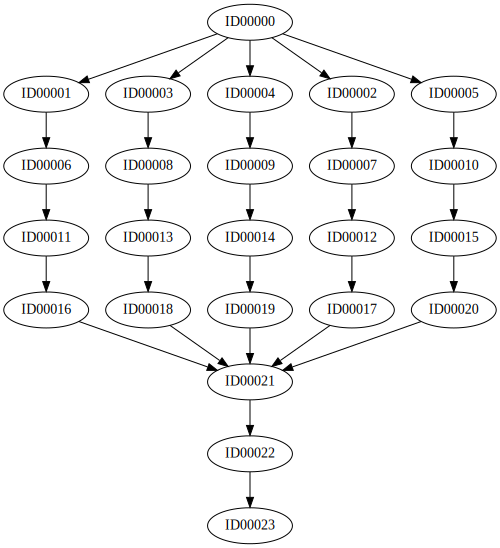

In [15]:
from shadow.models.workflow import Workflow
from shadow.visualiser.graph import convert_to_graphviz
workflow = Workflow('output/dax.json')
graph = convert_to_graphviz(workflow)
graph

# Widget setup
 [Back to top](#Table-of-Contents)

To make things easier and more fun(!) to interact with, this poster has `ipywidget` functionality. However, it is a bit cumbersome to have both SHADOW code and widget code in the same document, so I've created some helper functions to reduce the code cells that are needed to display the widgets. Running the following code cells will ensure you can use dropdown menus and radio buttons to your hearts content! 

 [Back to top](#Table-of-Contents)


In [16]:
from shadow.algorithms.heuristic import heft, pheft, fcfs
from ipywidgets import interact, widgets, TwoByTwoLayout
style = {'description_width': 'initial', 'width': 'auto'}

def ipywidget_algorithm_setup():

    algo = widgets.Dropdown(
        options=[('heft', heft), ('pheft', pheft), ('fcfs', fcfs)],
        # value='pineapple', # Defaults to 'pineapple'
        # layout={'width': 'max-content'}, # If the items' names are long
        description='Heuristic selection:',
        style=style,
        disabled=False
    )
    import os
    # os.chdir('../test/data/shadowgen/')
    file_list = [('Basic DAG', 'examples/dag.json'), ('Epigenomics Pipeline', 'examples/shadow_Epigenomics_24.json')]
    files = widgets.Dropdown(
        options=file_list,
    #    layout={'width': 'max-content'}, # If the items' names are long
        description='DAX Workflow File:',
        style=style,
        disabled=False
    )
    
    sys  = widgets.Dropdown(
        options=[('Basic system config', 'examples/sys.json')],
    #    layout={'width': 'max-content'}, # If the items' names are long
        description='DAX Workflow File:',
        style=style,
        disabled=False
    )
    
    
    return TwoByTwoLayout(top_left=algo,bottom_left=files, top_right=sys), algo, files, sys



def ipywidget_shadowgen_setup():
    style = {'description_width': 'initial', 'width': 'auto'}

    files = widgets.Dropdown(
        options=[
            ("HEFT Paper DAG","examples/HEFT_paper.xml"),
            ('Cybershake','examples/cybershake_30.xml'), 
            ('Epigenomics', 'examples/Epigenomics_24.xml'), 
            ('Montage', 'examples/Montage_25.xml')
        ],
        # value='pineapple', # Defaults to 'pineapple'
        # layout={'width': 'max-content'}, # If the items' names are long
        description='Heuristic selection:',
        style=style,
        disabled=False
    )


    return files

def ipywidget_models_setup():
    checkbox =  widgets.Checkbox(
        value=False,
        description='Check me',
        disabled=False,
        indent=False
    )
    task_selection = widgets.RadioButtons(
        options=[('SHADOW tasks', 'workflow.tasks'),('Networkx ','workflow.graph.nodes') ],
        description='SHADOW vs networkx tasks:',
        style=style,
        layout={'width':'max-content'},
        disabled=False
    )

    edge_selection = widgets.RadioButtons(
        options=[('SHADOW edges', 'workflow.edges'),('Networkx ','workflow.graph.edges') ],
        description='SHADOW vs networkx edges:',
        style=style,
        layout={'width':'max-content'},
        disabled=False
    )
    return TwoByTwoLayout(top_left=task_selection, top_right=edge_selection), task_selection,edge_selection

 [Back to top](#Table-of-Contents)
